In [1]:
import sys
import subprocess
import colorsys
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import Cell_BLAST as cb
cb.config.RANDOM_SEED = 0
cb.config.N_JOBS = 4

In [2]:
hsl2hex = lambda x: '#%02x%02x%02x' % tuple(int(i * 255) for i in colorsys.hls_to_rgb(x, 0.6, 0.8))
colors = np.linspace(0, 1, 8)[:-1].reshape((-1, 1))
fates = ["E", "Ba", "Meg", "Ly", "D", "M", "G"]

def jsd(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m))

def plot_fate(ds, s=3, width=6, height=6, sort=False):
    fig, ax = plt.subplots(figsize=(width, height))
    order = np.argsort(ds.obs["color"] != "#474747") if sort else np.arange(ds.shape[0])
    _ = plt.scatter(
        x=ds.obs["UMAP1"][order],
        y=ds.obs["UMAP2"][order],
        facecolors=ds.obs["color"][order],
        s=s, edgecolor=None
    )
    _ = plt.legend(handles=[
        mpatches.Patch(color=hsl2hex(c), label=f)
        for c, f in zip(colors, fates)
    ], frameon=False, bbox_to_anchor=(1.05, 0.5), loc="center left")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    return fig

# `Tusi`

In [3]:
tusi = cb.data.ExprDataSet.read_dataset("../../../Datasets/data/Tusi/data.h5").normalize()
tusi.obs.loc[tusi.obs["batch"] == "basal_bm1", "seq_run"] = "seq_run1"
tusi.obs.loc[tusi.obs["batch"] != "basal_bm1", "seq_run"] = "seq_run2"

fates = ["E", "Ba", "Meg", "Ly", "D", "M", "G"]
tmp = tusi.obs.loc[:, fates].values
tmp[tmp < 0] = 0  # Original values have very small negative numbers
tmp /= tmp.sum(axis=1, keepdims=True)
tusi.obs.loc[:, fates] = tmp

distribution = tusi.obs.loc[:, fates]
tusi.obs["entropy"] = np.sum(- distribution * np.log(distribution), axis=1)

hue = np.matmul(tusi.obs.loc[:, fates].values, colors)
tusi.obs["color"] = np.vectorize(hsl2hex)(hue.ravel())

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


### Inspect dataset with no batch correction

In [4]:
tusi_model = cb.directi.fit_DIRECTi(
    tusi, genes=tusi.uns["seurat_genes"],
    latent_dim=10, cat_dim=None,
    epoch=300, patience=20, random_seed=0,
    path="/tmp/cb/tusi/model_0"
)

[DIRECTi epoch 0] train=1.931, val=1.954, time elapsed=1.0s Best save...
[DIRECTi epoch 1] train=1.927, val=1.947, time elapsed=0.3s Best save...
[DIRECTi epoch 2] train=1.914, val=1.927, time elapsed=0.3s Best save...
[DIRECTi epoch 3] train=1.888, val=1.891, time elapsed=0.3s Best save...
[DIRECTi epoch 4] train=1.640, val=1.219, time elapsed=0.3s Best save...
[DIRECTi epoch 5] train=0.778, val=0.823, time elapsed=0.3s Best save...
[DIRECTi epoch 6] train=0.684, val=0.746, time elapsed=0.3s Best save...
[DIRECTi epoch 7] train=0.682, val=0.723, time elapsed=0.3s Best save...
[DIRECTi epoch 8] train=0.680, val=0.714, time elapsed=0.3s Best save...
[DIRECTi epoch 9] train=0.679, val=0.701, time elapsed=0.3s Best save...
[DIRECTi epoch 10] train=0.678, val=0.690, time elapsed=0.3s Best save...
[DIRECTi epoch 11] train=0.678, val=0.694, time elapsed=0.3s
[DIRECTi epoch 12] train=0.676, val=0.691, time elapsed=0.3s
[DIRECTi epoch 13] train=0.665, val=0.688, time elapsed=0.3s Best save...


[DIRECTi epoch 124] train=0.567, val=0.587, time elapsed=0.3s
[DIRECTi epoch 125] train=0.566, val=0.587, time elapsed=0.3s
[DIRECTi epoch 126] train=0.567, val=0.589, time elapsed=0.3s
[DIRECTi epoch 127] train=0.566, val=0.586, time elapsed=0.3s
[DIRECTi epoch 128] train=0.567, val=0.587, time elapsed=0.3s
[DIRECTi epoch 129] train=0.566, val=0.591, time elapsed=0.3s
[DIRECTi epoch 130] train=0.565, val=0.588, time elapsed=0.3s
[DIRECTi epoch 131] train=0.566, val=0.587, time elapsed=0.3s
[DIRECTi epoch 132] train=0.566, val=0.587, time elapsed=0.3s
[DIRECTi epoch 133] train=0.566, val=0.587, time elapsed=0.3s
[DIRECTi epoch 134] train=0.566, val=0.588, time elapsed=0.3s
[DIRECTi epoch 135] train=0.566, val=0.587, time elapsed=0.3s
[DIRECTi epoch 136] train=0.565, val=0.589, time elapsed=0.3s
[DIRECTi epoch 137] train=0.566, val=0.586, time elapsed=0.3s Best save...
[DIRECTi epoch 138] train=0.565, val=0.586, time elapsed=0.3s
[DIRECTi epoch 139] train=0.566, val=0.585, time elapsed=

In [5]:
tusi.latent = tusi_model.inference(tusi)

[  Info   ] Computing UMAP...


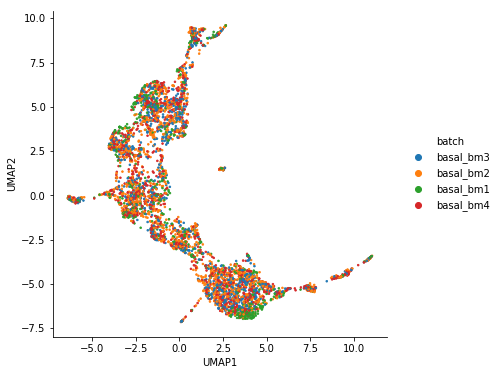

In [6]:
plot = tusi.visualize_latent("batch", method="UMAP", reuse=False, width=6, height=6, dr_kws=dict(n_neighbors=15))
plot.get_figure().savefig("./tusi_inspect_batch.pdf", bbox_inches="tight")

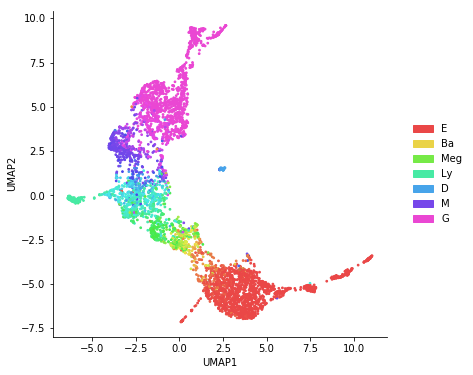

In [7]:
fig = plot_fate(tusi)
fig.savefig("./tusi_inspect_fate.pdf", bbox_inches="tight")

[  Info   ] Using cached UMAP...


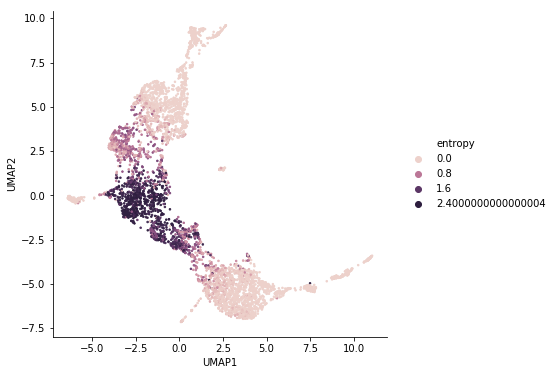

In [8]:
plot = tusi.visualize_latent("entropy", method="UMAP", width=6, height=6)
plot.get_figure().savefig("./tusi_inspect_entropy.pdf", bbox_inches="tight")

### Within dataset BLAST

In [9]:
ref = tusi[tusi.obs["seq_run"] == "seq_run2", :]
query = tusi[tusi.obs["seq_run"] == "seq_run1", :]
ref.write_dataset("./tusi_run2.h5")
query.write_dataset("./tusi_run1.h5")

#### scmap

In [10]:
p = subprocess.Popen([
    "./run_scmap.R",
    "-r", "../../Notebooks/Case/HSC/tusi_run2.h5", "-n", "ref",
    "-q", "../../Notebooks/Case/HSC/tusi_run1.h5",
    "-o", "../../Notebooks/Case/HSC/tusi_within_dataset_scmap.h5",
    "-g", "scmap_genes", "-s", "0", "--cluster-col", "organ"
], cwd="../../../Evaluation/scmap", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
(output, err) = p.communicate()
exit_code = p.wait()
print(output.decode())
print(err.decode())

Reading reference data...
Processing "../../Notebooks/Case/HSC/tusi_run2.h5"...
[1]  539 4016
Reading query data...
Performing scmap-cell...
[1] "Time: 3.313919 ms/cell"
Saving results...
Removing previous file...

Creating a generic function for ‘toJSON’ from package ‘jsonlite’ in package ‘googleVis’
Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.
Parameter k was not provided, will use k = sqrt(number_of_cells)
Done!



In [11]:
scmap_idx = cb.data.read_hybrid_path("./tusi_within_dataset_scmap.h5//scmap_cell/nn/ref/cells").astype(int)
scmap_sim = cb.data.read_hybrid_path("./tusi_within_dataset_scmap.h5//scmap_cell/nn/ref/similarities")

In [12]:
fate_pred_scmap = pd.DataFrame([
    ref.obs.iloc[_idx[_sim >= 0.5] - 1, :].loc[:, fates].mean(axis=0)
    for _idx, _sim in zip(scmap_idx, scmap_sim)
])  # idx - 1 because R idx is 1 based

In [13]:
reject_mask = np.isnan(fate_pred_scmap.values).sum(axis=1) > 0
reject_mask.sum() / reject_mask.size

0.0535475234270415

In [14]:
fate_pred_scmap_jsd = np.array([
    jsd(p, q) for p, q in
    zip(fate_pred_scmap.values[~reject_mask], query.obs.loc[:, fates].values[~reject_mask])
])
assert np.isinf(fate_pred_scmap_jsd).sum() == 0

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


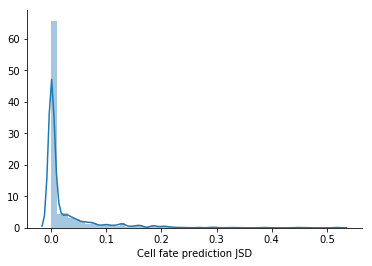

In [15]:
plot = sns.distplot(fate_pred_scmap_jsd, axlabel="Cell fate prediction JSD")
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)
plot.yaxis.set_ticks_position("left")
plot.xaxis.set_ticks_position("bottom")
plot.get_figure().savefig("tusi_within_dataset_scmap_jsd.pdf", bbox_inches="tight")

#### Cell BLAST

In [16]:
within_dataset_blast_models = []
for i in range(4):
    within_dataset_blast_models.append(cb.directi.fit_DIRECTi(
        ref, genes=ref.uns["seurat_genes"],
        latent_dim=10, cat_dim=None,
        epoch=300, patience=20, random_seed=i,
        path="/tmp/cb/tusi/within_dataset_blast/model_%d" % i
    ))

[DIRECTi epoch 0] train=1.954, val=1.979, time elapsed=0.9s Best save...
[DIRECTi epoch 1] train=1.952, val=1.976, time elapsed=0.2s Best save...
[DIRECTi epoch 2] train=1.944, val=1.963, time elapsed=0.3s Best save...
[DIRECTi epoch 3] train=1.926, val=1.940, time elapsed=0.3s Best save...
[DIRECTi epoch 4] train=1.897, val=1.898, time elapsed=0.3s Best save...
[DIRECTi epoch 5] train=1.524, val=1.141, time elapsed=0.2s Best save...
[DIRECTi epoch 6] train=0.754, val=1.046, time elapsed=0.3s Best save...
[DIRECTi epoch 7] train=0.682, val=0.766, time elapsed=0.3s Best save...
[DIRECTi epoch 8] train=0.679, val=0.732, time elapsed=0.3s Best save...
[DIRECTi epoch 9] train=0.678, val=0.713, time elapsed=0.3s Best save...
[DIRECTi epoch 10] train=0.676, val=0.701, time elapsed=0.3s Best save...
[DIRECTi epoch 11] train=0.676, val=0.700, time elapsed=0.3s Best save...
[DIRECTi epoch 12] train=0.676, val=0.694, time elapsed=0.3s Best save...
[DIRECTi epoch 13] train=0.675, val=0.694, time 

[DIRECTi epoch 125] train=0.569, val=0.592, time elapsed=0.2s
[DIRECTi epoch 126] train=0.568, val=0.594, time elapsed=0.3s
[DIRECTi epoch 127] train=0.569, val=0.592, time elapsed=0.3s
[DIRECTi epoch 128] train=0.568, val=0.593, time elapsed=0.2s
[DIRECTi epoch 129] train=0.568, val=0.592, time elapsed=0.3s
[DIRECTi epoch 130] train=0.568, val=0.593, time elapsed=0.3s
[DIRECTi epoch 131] train=0.567, val=0.593, time elapsed=0.2s
[DIRECTi epoch 132] train=0.568, val=0.591, time elapsed=0.3s
[DIRECTi epoch 133] train=0.568, val=0.591, time elapsed=0.2s
[DIRECTi epoch 134] train=0.568, val=0.592, time elapsed=0.3s
[DIRECTi epoch 135] train=0.567, val=0.591, time elapsed=0.2s
Restoring best model...
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/within_dataset_blast/model_0/checkpoint-115
[DIRECTi epoch 0] train=1.952, val=2.007, time elapsed=0.9s Best save...
[DIRECTi epoch 1] train=1.948, val=2.003, time elapsed=0.3s Best save...
[DIRECTi epoch 2] train=1.942, val=1.990, time el

[DIRECTi epoch 111] train=0.570, val=0.586, time elapsed=0.3s
[DIRECTi epoch 112] train=0.571, val=0.585, time elapsed=0.2s
[DIRECTi epoch 113] train=0.570, val=0.586, time elapsed=0.3s
[DIRECTi epoch 114] train=0.570, val=0.585, time elapsed=0.2s
[DIRECTi epoch 115] train=0.570, val=0.593, time elapsed=0.3s
[DIRECTi epoch 116] train=0.570, val=0.585, time elapsed=0.3s Best save...
[DIRECTi epoch 117] train=0.569, val=0.584, time elapsed=0.3s Best save...
[DIRECTi epoch 118] train=0.569, val=0.585, time elapsed=0.3s
[DIRECTi epoch 119] train=0.569, val=0.588, time elapsed=0.3s
[DIRECTi epoch 120] train=0.569, val=0.586, time elapsed=0.3s
[DIRECTi epoch 121] train=0.569, val=0.587, time elapsed=0.2s
[DIRECTi epoch 122] train=0.569, val=0.587, time elapsed=0.3s
[DIRECTi epoch 123] train=0.568, val=0.585, time elapsed=0.3s
[DIRECTi epoch 124] train=0.569, val=0.585, time elapsed=0.3s
[DIRECTi epoch 125] train=0.569, val=0.586, time elapsed=0.2s
[DIRECTi epoch 126] train=0.568, val=0.586, 

[DIRECTi epoch 97] train=0.574, val=0.594, time elapsed=0.3s
[DIRECTi epoch 98] train=0.574, val=0.591, time elapsed=0.2s Best save...
[DIRECTi epoch 99] train=0.573, val=0.593, time elapsed=0.2s
[DIRECTi epoch 100] train=0.573, val=0.592, time elapsed=0.3s
[DIRECTi epoch 101] train=0.573, val=0.591, time elapsed=0.2s Best save...
[DIRECTi epoch 102] train=0.572, val=0.591, time elapsed=0.2s
[DIRECTi epoch 103] train=0.572, val=0.591, time elapsed=0.3s
[DIRECTi epoch 104] train=0.572, val=0.590, time elapsed=0.2s Best save...
[DIRECTi epoch 105] train=0.572, val=0.590, time elapsed=0.2s
[DIRECTi epoch 106] train=0.571, val=0.590, time elapsed=0.3s Best save...
[DIRECTi epoch 107] train=0.572, val=0.589, time elapsed=0.2s Best save...
[DIRECTi epoch 108] train=0.571, val=0.590, time elapsed=0.2s
[DIRECTi epoch 109] train=0.571, val=0.590, time elapsed=0.3s
[DIRECTi epoch 110] train=0.570, val=0.590, time elapsed=0.3s
[DIRECTi epoch 111] train=0.570, val=0.591, time elapsed=0.3s
[DIRECTi

[DIRECTi epoch 75] train=0.581, val=0.589, time elapsed=0.3s Best save...
[DIRECTi epoch 76] train=0.580, val=0.591, time elapsed=0.3s
[DIRECTi epoch 77] train=0.580, val=0.589, time elapsed=0.3s
[DIRECTi epoch 78] train=0.579, val=0.589, time elapsed=0.2s Best save...
[DIRECTi epoch 79] train=0.579, val=0.590, time elapsed=0.3s
[DIRECTi epoch 80] train=0.578, val=0.589, time elapsed=0.3s Best save...
[DIRECTi epoch 81] train=0.578, val=0.589, time elapsed=0.2s
[DIRECTi epoch 82] train=0.578, val=0.588, time elapsed=0.3s Best save...
[DIRECTi epoch 83] train=0.578, val=0.594, time elapsed=0.2s
[DIRECTi epoch 84] train=0.578, val=0.589, time elapsed=0.3s
[DIRECTi epoch 85] train=0.577, val=0.591, time elapsed=0.2s
[DIRECTi epoch 86] train=0.578, val=0.591, time elapsed=0.2s
[DIRECTi epoch 87] train=0.577, val=0.590, time elapsed=0.3s
[DIRECTi epoch 88] train=0.576, val=0.589, time elapsed=0.3s
[DIRECTi epoch 89] train=0.576, val=0.587, time elapsed=0.2s Best save...
[DIRECTi epoch 90] t

In [17]:
blast = cb.blast.BLAST(
    within_dataset_blast_models, ref, keep_exprs=True
).build_empirical()

[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Computing posterior distribution distances...


In [18]:
hits = blast.query(query)

[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...


In [19]:
fate_pred_cbpd = hits.reconcile_models().filter("pval", 0.05).annotate(fates, min_hits=1)

In [20]:
reject_mask = np.isnan(fate_pred_cbpd.values).sum(axis=1) > 0
reject_mask.sum() / reject_mask.size

0.09103078982597054

In [21]:
fate_pred_cbpd_jsd = np.array([
    jsd(p, q) for p, q in
    zip(fate_pred_cbpd.values[~reject_mask], query.obs.loc[:, fates].values[~reject_mask])
])
assert np.isinf(fate_pred_cbpd_jsd).sum() == 0

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


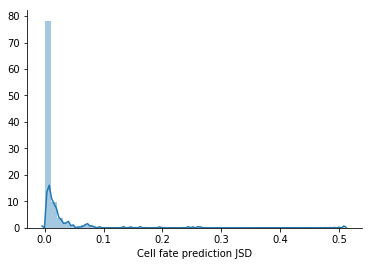

In [22]:
plot = sns.distplot(fate_pred_cbpd_jsd, axlabel="Cell fate prediction JSD")
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)
plot.yaxis.set_ticks_position("left")
plot.xaxis.set_ticks_position("bottom")
plot.get_figure().savefig("tusi_within_dataset_blast_jsd.pdf", bbox_inches="tight")

In [23]:
tusi.latent = blast.models[0].inference(tusi)

[  Info   ] Computing UMAP...


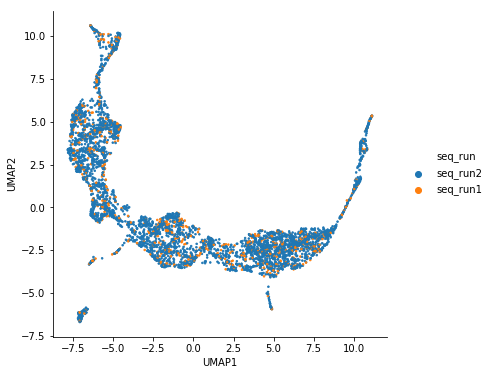

In [24]:
plot = tusi.visualize_latent(
    "seq_run", method="UMAP", reuse=False, width=6, height=6, dr_kws=dict(n_neighbors=15))
plot.get_figure().savefig("./tusi_within_dataset_blast_run.pdf", bbox_inches="tight")

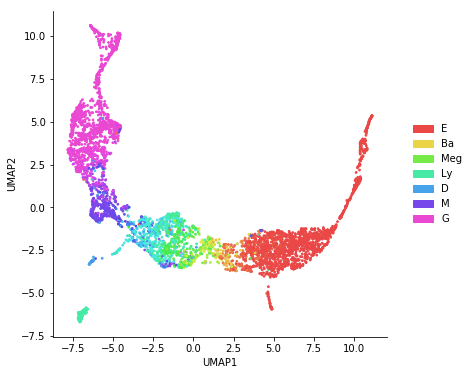

In [25]:
fig = plot_fate(tusi)
fig.savefig("./tusi_within_dataset_blast_fate.pdf", bbox_inches="tight")

#### Compare JSD

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


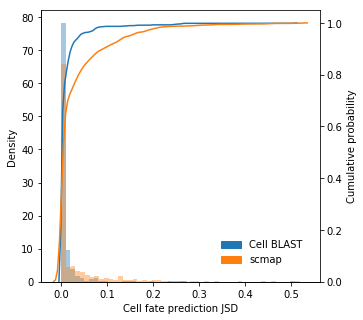

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
ax2 = ax.twinx()
ax = sns.distplot(
    fate_pred_cbpd_jsd, color=sns.color_palette()[0],
    kde=False, hist_kws=dict(density=True),
    axlabel="Cell fate prediction JSD", ax=ax
)
ax2 = sns.distplot(
    fate_pred_cbpd_jsd, color=sns.color_palette()[0],
    hist=False, kde_kws=dict(cumulative=True),
    axlabel="Cell fate prediction JSD", ax=ax2
)
ax = sns.distplot(
    fate_pred_scmap_jsd, color=sns.color_palette()[1],
    kde=False, hist_kws=dict(density=True),
    axlabel="Cell fate prediction JSD", ax=ax
)
ax2 = sns.distplot(
    fate_pred_scmap_jsd, color=sns.color_palette()[1],
    hist=False, kde_kws=dict(cumulative=True),
    axlabel="Cell fate prediction JSD", ax=ax2
)
ax.set_ylabel("Density")
ax2.set_ylabel("Cumulative probability")
_ = plt.legend(handles=[
    mpatches.Patch(color=c, label=l)
    for c, l in zip(sns.color_palette()[0:2], ["Cell BLAST", "scmap"])
], frameon=False, bbox_to_anchor=(0.97, 0.03), loc="lower right")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.savefig("./tusi_within_dataset_jsd_cmp.pdf", bbox_inches="tight")

# Cross species BLAST

In [27]:
velten = cb.data.ExprDataSet.read_dataset("../../../Datasets/data/Velten_Smart-seq2/data.h5").normalize()
velten.obs["plate"] = np.vectorize(lambda x: x.split("_")[1])(velten.obs.index)

In [28]:
human2mouse = pd.read_csv("../../../Datasets/ortholog/Ensembl/orthology/9606_10090.csv", header=None)
velten2mouse = velten.map_vars(human2mouse.iloc[:, [1, 3]], map_uns_slots=["seurat_genes"])

[ Warning ] 362 ambiguous source items found!
[ Warning ] 186 ambiguous target items found!


In [29]:
tv = cb.data.ExprDataSet.merge_datasets(dict(
    tusi=tusi, velten=velten2mouse
), merge_uns_slots=["seurat_genes"])

[ Warning ] 426 out of 28631 variables are not found, will be set to zero!
[ Warning ] 16882 out of 28631 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/Cell_BLAST/data.py:579: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  merged_obs = pd.concat(merged_obs)


### Not aligned

In [30]:
tusi_models = [tusi_model]
for i in range(1, 4):
    tusi_models.append(cb.directi.fit_DIRECTi(
        tusi, genes=tusi.uns["seurat_genes"],
        latent_dim=10, cat_dim=None,
        epoch=300, patience=20, random_seed=i,
        path="/tmp/cb/tusi/model_%d" % i
    ))
blast = cb.blast.BLAST(tusi_models, tusi, keep_exprs=True).build_empirical()
blast.save("./tusi_blast")

[DIRECTi epoch 0] train=1.933, val=1.933, time elapsed=0.8s Best save...
[DIRECTi epoch 1] train=1.929, val=1.926, time elapsed=0.3s Best save...
[DIRECTi epoch 2] train=1.918, val=1.906, time elapsed=0.3s Best save...
[DIRECTi epoch 3] train=1.891, val=1.870, time elapsed=0.3s Best save...
[DIRECTi epoch 4] train=1.607, val=1.156, time elapsed=0.3s Best save...
[DIRECTi epoch 5] train=0.757, val=0.925, time elapsed=0.3s Best save...
[DIRECTi epoch 6] train=0.683, val=0.863, time elapsed=0.3s Best save...
[DIRECTi epoch 7] train=0.681, val=0.746, time elapsed=0.3s Best save...
[DIRECTi epoch 8] train=0.680, val=0.733, time elapsed=0.3s Best save...
[DIRECTi epoch 9] train=0.679, val=0.717, time elapsed=0.3s Best save...
[DIRECTi epoch 10] train=0.677, val=0.700, time elapsed=0.3s Best save...
[DIRECTi epoch 11] train=0.676, val=0.705, time elapsed=0.3s
[DIRECTi epoch 12] train=0.663, val=0.673, time elapsed=0.3s Best save...
[DIRECTi epoch 13] train=0.645, val=0.680, time elapsed=0.3s


[DIRECTi epoch 124] train=0.566, val=0.591, time elapsed=0.3s Best save...
[DIRECTi epoch 125] train=0.566, val=0.591, time elapsed=0.3s
[DIRECTi epoch 126] train=0.566, val=0.591, time elapsed=0.3s
[DIRECTi epoch 127] train=0.566, val=0.592, time elapsed=0.3s
[DIRECTi epoch 128] train=0.566, val=0.591, time elapsed=0.3s
[DIRECTi epoch 129] train=0.566, val=0.593, time elapsed=0.3s
[DIRECTi epoch 130] train=0.566, val=0.591, time elapsed=0.6s Best save...
[DIRECTi epoch 131] train=0.566, val=0.590, time elapsed=0.3s Best save...
[DIRECTi epoch 132] train=0.565, val=0.591, time elapsed=0.3s
[DIRECTi epoch 133] train=0.565, val=0.592, time elapsed=0.3s
[DIRECTi epoch 134] train=0.565, val=0.591, time elapsed=0.3s
[DIRECTi epoch 135] train=0.565, val=0.590, time elapsed=0.3s Best save...
[DIRECTi epoch 136] train=0.566, val=0.592, time elapsed=0.3s
[DIRECTi epoch 137] train=0.565, val=0.592, time elapsed=0.3s
[DIRECTi epoch 138] train=0.565, val=0.592, time elapsed=0.3s
[DIRECTi epoch 139

[DIRECTi epoch 90] train=0.573, val=0.596, time elapsed=0.3s
[DIRECTi epoch 91] train=0.573, val=0.595, time elapsed=0.3s
[DIRECTi epoch 92] train=0.572, val=0.596, time elapsed=0.3s
[DIRECTi epoch 93] train=0.572, val=0.595, time elapsed=0.3s
[DIRECTi epoch 94] train=0.572, val=0.597, time elapsed=0.3s
[DIRECTi epoch 95] train=0.572, val=0.594, time elapsed=0.3s Best save...
[DIRECTi epoch 96] train=0.572, val=0.596, time elapsed=0.3s
[DIRECTi epoch 97] train=0.571, val=0.595, time elapsed=0.3s
[DIRECTi epoch 98] train=0.571, val=0.595, time elapsed=0.3s
[DIRECTi epoch 99] train=0.570, val=0.595, time elapsed=0.3s
[DIRECTi epoch 100] train=0.571, val=0.596, time elapsed=0.3s
[DIRECTi epoch 101] train=0.570, val=0.594, time elapsed=0.3s Best save...
[DIRECTi epoch 102] train=0.570, val=0.596, time elapsed=0.3s
[DIRECTi epoch 103] train=0.570, val=0.594, time elapsed=0.4s
[DIRECTi epoch 104] train=0.570, val=0.595, time elapsed=0.3s
[DIRECTi epoch 105] train=0.569, val=0.595, time elaps

[DIRECTi epoch 42] train=0.588, val=0.608, time elapsed=0.3s
[DIRECTi epoch 43] train=0.588, val=0.605, time elapsed=0.3s Best save...
[DIRECTi epoch 44] train=0.587, val=0.605, time elapsed=0.3s
[DIRECTi epoch 45] train=0.586, val=0.611, time elapsed=0.3s
[DIRECTi epoch 46] train=0.586, val=0.604, time elapsed=0.3s Best save...
[DIRECTi epoch 47] train=0.585, val=0.604, time elapsed=0.3s Best save...
[DIRECTi epoch 48] train=0.585, val=0.605, time elapsed=0.3s
[DIRECTi epoch 49] train=0.584, val=0.601, time elapsed=0.3s Best save...
[DIRECTi epoch 50] train=0.584, val=0.601, time elapsed=0.3s
[DIRECTi epoch 51] train=0.583, val=0.603, time elapsed=0.3s
[DIRECTi epoch 52] train=0.583, val=0.600, time elapsed=0.3s Best save...
[DIRECTi epoch 53] train=0.583, val=0.602, time elapsed=0.3s
[DIRECTi epoch 54] train=0.582, val=0.602, time elapsed=0.3s
[DIRECTi epoch 55] train=0.582, val=0.600, time elapsed=0.3s
[DIRECTi epoch 56] train=0.582, val=0.601, time elapsed=0.3s
[DIRECTi epoch 57] t

In [31]:
hits = blast.query(velten2mouse)

[  Info   ] Projecting to latent space...
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...


In [32]:
fhits = hits.reconcile_models().filter("pval", 0.1)
for fate in fates:
    velten2mouse.obs[fate] = fhits.annotate(fate).values

In [33]:
_ = np.isnan(velten2mouse.obs["E"])
_.sum() / _.size

0.927536231884058

Mostly rejected

### Aligned

In [34]:
blast_aligned = blast.align(
    velten2mouse, rmbatch_module_kwargs=dict(lambda_reg=0.01),
    epoch=200, patience=np.nan,
    path="/tmp/cb/tusi/cross_species_blast_align"
).build_empirical()

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site

[  Info   ] Loading latent module weights...
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/latent/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/latent/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/latent/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/latent/save.ckpt
[  Info   ] Loading latent module weights...
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/latent/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_2/unaligned/latent/save.ckpt
[  Info   ] Loading latent module weights...
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_2/unaligned/latent/save.ck

INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_3/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_2/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_1/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_3/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_0/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_2/unaligned/prob/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_1/unaligned/prob/save.ckpt
INFO:tensorflow:Restorin

[ Warning ] 8 variables failed to load!
[<tf.Variable 'decoder/NB/mlp/layer_0/dense/weights_ori:0' shape=(10, 128) dtype=float32_ref>, <tf.Variable 'decoder/NB/mlp/layer_0/dense/weights_1:0' shape=(2, 128) dtype=float32_ref>, <tf.Variable 'decoder/NB/mlp/layer_0/dense/weights_1_ori:0' shape=(2, 128) dtype=float32_ref>, <tf.Variable 'decoder/NB/mlp/layer_0/dense/bias_ori:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'decoder/NB/softmax_mu_dense/weights_ori:0' shape=(128, 897) dtype=float32_ref>, <tf.Variable 'decoder/NB/softmax_mu_dense/bias_ori:0' shape=(897,) dtype=float32_ref>, <tf.Variable 'decoder/NB/log_theta_dense/weights_ori:0' shape=(128, 897) dtype=float32_ref>, <tf.Variable 'decoder/NB/log_theta_dense/bias_ori:0' shape=(897,) dtype=float32_ref>]
[  Info   ] Loading rmbatch module weights...
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi/cross_species_blast_align/aligned_model_1/unaligned/rmbatch/align/save.ckpt
INFO:tensorflow:Restoring parameters from /tmp/cb/tusi

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/Cell_BLAST/data.py:579: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  merged_obs = pd.concat(merged_obs)


[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[DIRECTi epoch 0] train=0.634, val=0.650, time elapsed=2.2s
[DIRECTi epoch 1] train=0.633, val=0.647, time elapsed=0.4s
[DIRECTi epoch 0] train=0.638, val=0.659, time elapsed=1.9s
[DIRECTi epoch 2] train=0.631, val=0.646, time elapsed=0.7s
[DIRECTi epoch 0] train=0.639, val=0.656, time elapsed=1.9s
[DIRECTi epoch 1] train=0.636, 

[DIRECTi epoch 31] train=0.581, val=0.604, time elapsed=0.8s
[DIRECTi epoch 30] train=0.582, val=0.606, time elapsed=0.8s
[DIRECTi epoch 33] train=0.580, val=0.604, time elapsed=0.8s
[DIRECTi epoch 31] train=0.581, val=0.603, time elapsed=0.8s
[DIRECTi epoch 32] train=0.580, val=0.604, time elapsed=0.7s
[DIRECTi epoch 31] train=0.582, val=0.605, time elapsed=0.7s
[DIRECTi epoch 34] train=0.580, val=0.606, time elapsed=0.8s
[DIRECTi epoch 32] train=0.581, val=0.604, time elapsed=0.7s
[DIRECTi epoch 33] train=0.580, val=0.604, time elapsed=0.7s
[DIRECTi epoch 32] train=0.582, val=0.604, time elapsed=0.7s
[DIRECTi epoch 35] train=0.580, val=0.605, time elapsed=0.8s
[DIRECTi epoch 33] train=0.581, val=0.603, time elapsed=0.8s
[DIRECTi epoch 34] train=0.580, val=0.604, time elapsed=0.8s
[DIRECTi epoch 33] train=0.582, val=0.605, time elapsed=0.7s
[DIRECTi epoch 34] train=0.580, val=0.604, time elapsed=0.8s
[DIRECTi epoch 36] train=0.579, val=0.606, time elapsed=0.8s
[DIRECTi epoch 35] train

[DIRECTi epoch 64] train=0.578, val=0.604, time elapsed=0.7s
[DIRECTi epoch 65] train=0.576, val=0.602, time elapsed=0.8s
[DIRECTi epoch 67] train=0.576, val=0.603, time elapsed=0.8s
[DIRECTi epoch 66] train=0.576, val=0.604, time elapsed=0.7s
[DIRECTi epoch 65] train=0.577, val=0.604, time elapsed=0.7s
[DIRECTi epoch 66] train=0.577, val=0.603, time elapsed=0.8s
[DIRECTi epoch 68] train=0.576, val=0.605, time elapsed=0.8s
[DIRECTi epoch 67] train=0.576, val=0.602, time elapsed=0.7s
[DIRECTi epoch 66] train=0.578, val=0.605, time elapsed=0.7s
[DIRECTi epoch 67] train=0.577, val=0.602, time elapsed=0.8s
[DIRECTi epoch 69] train=0.576, val=0.603, time elapsed=0.8s
[DIRECTi epoch 68] train=0.576, val=0.604, time elapsed=0.8s
[DIRECTi epoch 67] train=0.578, val=0.603, time elapsed=0.7s
[DIRECTi epoch 68] train=0.576, val=0.603, time elapsed=0.8s
[DIRECTi epoch 69] train=0.576, val=0.602, time elapsed=0.7s
[DIRECTi epoch 70] train=0.575, val=0.608, time elapsed=0.8s
[DIRECTi epoch 68] train

[DIRECTi epoch 98] train=0.577, val=0.610, time elapsed=0.7s
[DIRECTi epoch 100] train=0.576, val=0.607, time elapsed=0.8s
[DIRECTi epoch 99] train=0.574, val=0.603, time elapsed=0.7s
[DIRECTi epoch 100] train=0.576, val=0.606, time elapsed=0.7s
[DIRECTi epoch 101] train=0.576, val=0.606, time elapsed=0.7s
[DIRECTi epoch 99] train=0.577, val=0.606, time elapsed=0.7s
[DIRECTi epoch 100] train=0.574, val=0.603, time elapsed=0.8s
[DIRECTi epoch 101] train=0.576, val=0.606, time elapsed=0.8s
[DIRECTi epoch 102] train=0.576, val=0.607, time elapsed=0.7s
[DIRECTi epoch 100] train=0.576, val=0.606, time elapsed=0.7s
[DIRECTi epoch 101] train=0.574, val=0.603, time elapsed=0.7s
[DIRECTi epoch 102] train=0.576, val=0.606, time elapsed=0.7s
[DIRECTi epoch 103] train=0.576, val=0.606, time elapsed=0.7s
[DIRECTi epoch 101] train=0.576, val=0.605, time elapsed=0.7s
[DIRECTi epoch 102] train=0.574, val=0.604, time elapsed=0.8s
[DIRECTi epoch 103] train=0.577, val=0.605, time elapsed=0.7s
[DIRECTi ep

[DIRECTi epoch 133] train=0.574, val=0.604, time elapsed=0.8s
[DIRECTi epoch 132] train=0.575, val=0.608, time elapsed=0.8s
[DIRECTi epoch 132] train=0.575, val=0.605, time elapsed=0.8s
[DIRECTi epoch 134] train=0.573, val=0.604, time elapsed=0.8s
[DIRECTi epoch 134] train=0.573, val=0.604, time elapsed=0.7s
[DIRECTi epoch 133] train=0.577, val=0.607, time elapsed=0.8s
[DIRECTi epoch 135] train=0.573, val=0.606, time elapsed=0.8s
[DIRECTi epoch 133] train=0.575, val=0.604, time elapsed=0.9s
[DIRECTi epoch 135] train=0.574, val=0.605, time elapsed=0.8s
[DIRECTi epoch 134] train=0.575, val=0.608, time elapsed=0.8s
[DIRECTi epoch 136] train=0.573, val=0.605, time elapsed=0.8s
[DIRECTi epoch 134] train=0.574, val=0.604, time elapsed=0.8s
[DIRECTi epoch 136] train=0.573, val=0.605, time elapsed=0.7s
[DIRECTi epoch 135] train=0.576, val=0.608, time elapsed=0.7s
[DIRECTi epoch 137] train=0.573, val=0.605, time elapsed=0.8s
[DIRECTi epoch 137] train=0.573, val=0.604, time elapsed=0.8s
[DIRECTi

[DIRECTi epoch 167] train=0.572, val=0.606, time elapsed=0.8s
[DIRECTi epoch 167] train=0.571, val=0.606, time elapsed=0.7s
[DIRECTi epoch 166] train=0.573, val=0.606, time elapsed=0.7s
[DIRECTi epoch 165] train=0.573, val=0.607, time elapsed=0.8s
[DIRECTi epoch 168] train=0.571, val=0.605, time elapsed=0.7s
[DIRECTi epoch 168] train=0.571, val=0.604, time elapsed=0.8s
[DIRECTi epoch 167] train=0.572, val=0.605, time elapsed=0.7s
[DIRECTi epoch 166] train=0.573, val=0.605, time elapsed=0.8s
[DIRECTi epoch 169] train=0.571, val=0.605, time elapsed=0.8s
[DIRECTi epoch 169] train=0.571, val=0.606, time elapsed=0.9s
[DIRECTi epoch 168] train=0.572, val=0.604, time elapsed=0.7s
[DIRECTi epoch 167] train=0.573, val=0.606, time elapsed=0.7s
[DIRECTi epoch 170] train=0.571, val=0.606, time elapsed=0.7s
[DIRECTi epoch 170] train=0.572, val=0.605, time elapsed=0.8s
[DIRECTi epoch 169] train=0.572, val=0.605, time elapsed=2.4s
[DIRECTi epoch 168] train=0.572, val=0.605, time elapsed=2.5s
[DIRECTi

[DIRECTi epoch 199] train=0.571, val=0.606, time elapsed=0.3s
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Computing posterior distribution distances...


In [35]:
hits = blast_aligned.query(velten2mouse)

[  Info   ] Projecting to latent space...
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[ Warning ] 173 out of 897 variables are not found, will be set to zero!
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...


In [36]:
fhits = hits.reconcile_models().filter("pval", 0.05)
for fate in fates:
    velten2mouse.obs[fate] = fhits.annotate(fate, min_hits=1).values

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [37]:
_ = np.isnan(velten2mouse.obs["E"])
_.sum() / _.size

0.06183574879227053

In [38]:
tv.latent = blast_aligned.models[1].inference(tv)

[  Info   ] Computing UMAP...


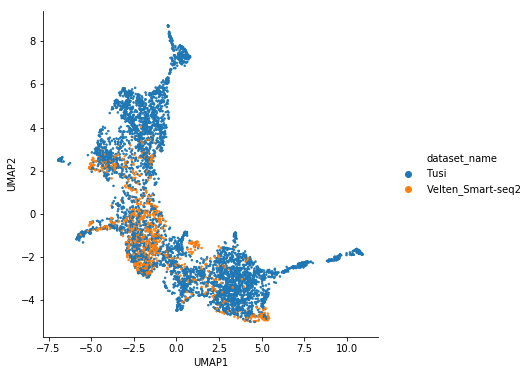

In [39]:
plot = tv.visualize_latent(
    "dataset_name", method="UMAP", reuse=False, width=6, height=6, dr_kws=dict(n_neighbors=15))
plot.get_figure().savefig("./tv_dataset_name.pdf", bbox_inches="tight")

### Visualize combined

In [40]:
colors = np.linspace(0, 1, 8)[:-1].reshape((-1, 1))
hue = np.matmul(tv.obs.loc[:, fates].values, colors)
hsl2hex = lambda x: '#%02x%02x%02x' % tuple(int(i * 255) for i in colorsys.hls_to_rgb(x, 0.6, 0.8))
tv.obs["color"] = np.vectorize(hsl2hex)(hue.ravel())
tv.obs.loc[tv.obs["dataset_name"] == "Velten_smart-seq2", "color"] = "#000000"

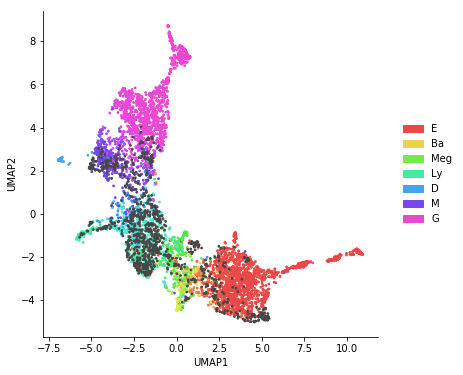

In [41]:
fig = plot_fate(tv)
fig.savefig("tv_fate_nopred.pdf", bbox_inches="tight")

### Visualize prediction

In [42]:
tv_v = tv[tv.obs["dataset_name"] == "Velten_Smart-seq2", :]
tv_v.obs.loc[:, fates] = velten2mouse.obs.loc[:, fates]
colors = np.linspace(0, 1, 8)[:-1].reshape((-1, 1))
hue = np.matmul(tv_v.obs.loc[:, fates].values, colors)
hsl2hex = lambda x: '#%02x%02x%02x' % tuple(int(i * 255) for i in colorsys.hls_to_rgb(x, 0.6, 0.8))
tv_v.obs["color"] = np.vectorize(hsl2hex)(hue.ravel())

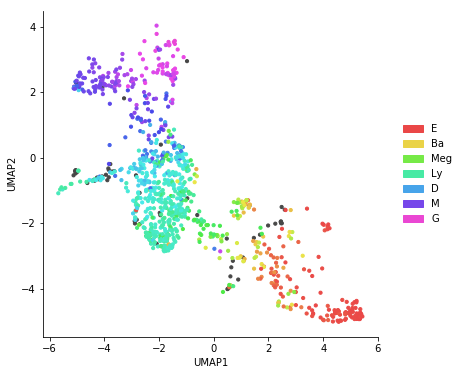

In [43]:
fig = plot_fate(tv_v, s=10, sort=True)
fig.savefig("velten_pred.pdf", bbox_inches="tight")

## Check gene expression

In [44]:
tv_v_use = tv_v[~np.isnan(tv_v.obs["E"]), :]
velten_use = velten[tv_v_use.obs_names, :]
velten_use.latent = tv_v_use.latent
velten_use.obs["UMAP1"] = tv_v_use.obs["UMAP1"]
velten_use.obs["UMAP2"] = tv_v_use.obs["UMAP2"]

In [45]:
def plot_genes(genes):
    for gene in genes:
        plot = velten_use.visualize_latent(
            gene, method="UMAP", size=10, shuffle=False, sort=True,
            width=6, height=6
        )
        plot.get_figure().savefig("./velten_%s.pdf" % gene, bbox_inches="tight")

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


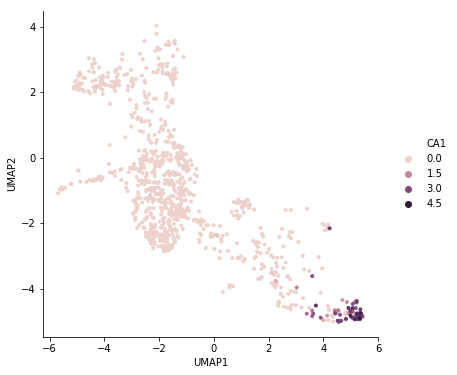

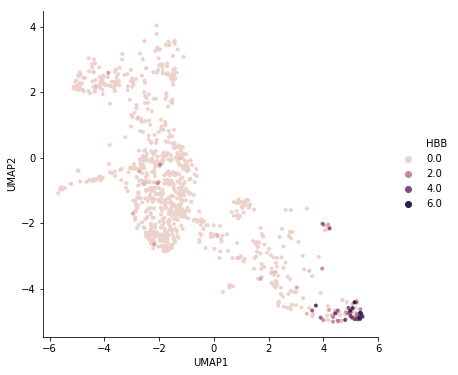

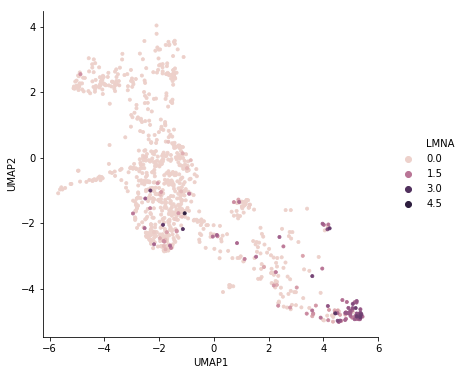

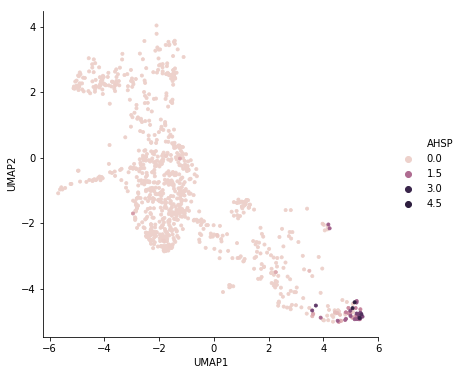

In [46]:
plot_genes(["CA1", "HBB", "LMNA", "AHSP"])  # Erythrocyte

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


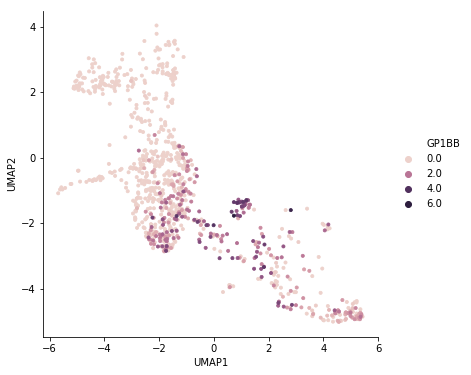

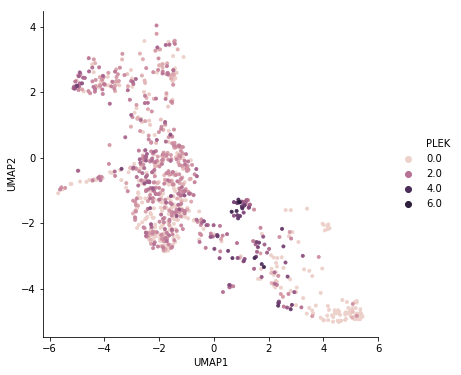

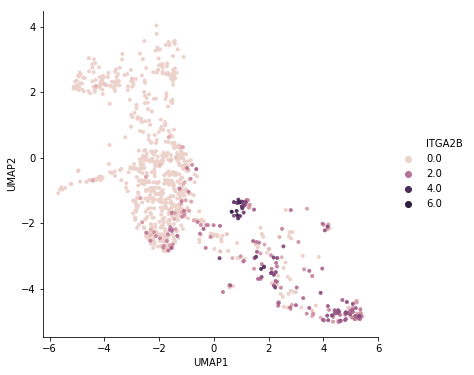

In [47]:
plot_genes(["GP1BB", "PLEK", "ITGA2B"])  # Megakaryocyte

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


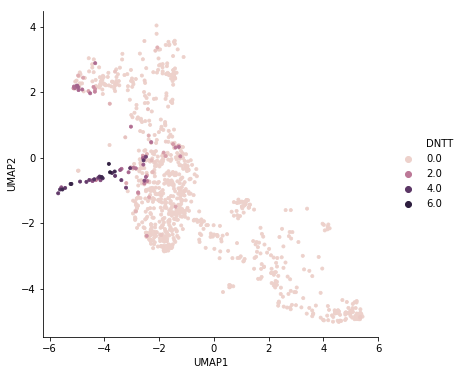

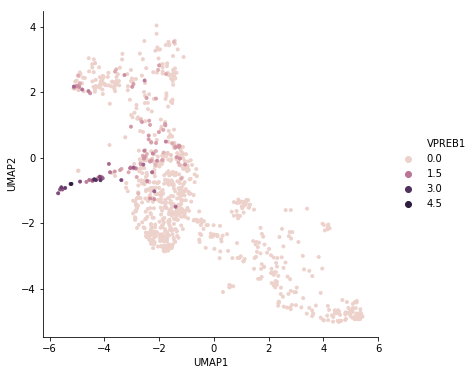

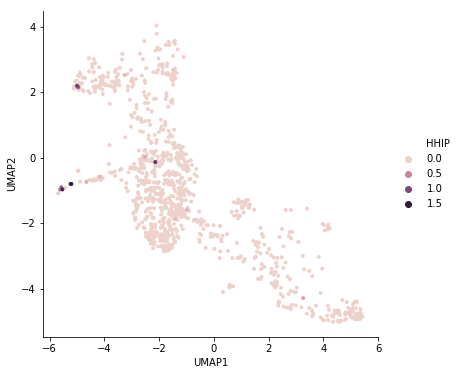

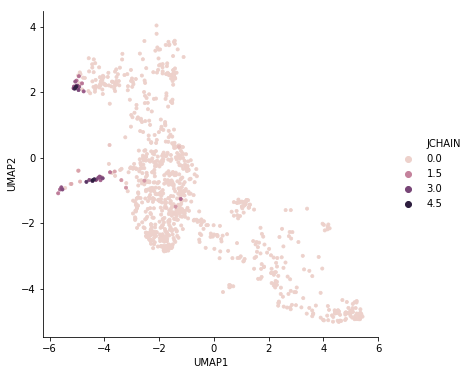

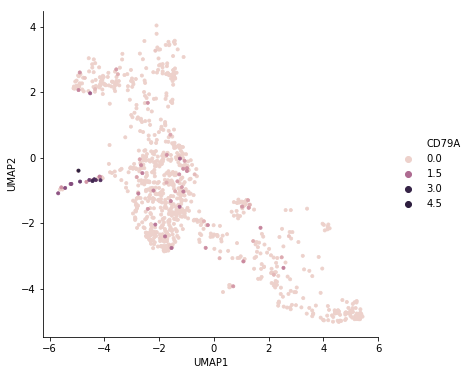

In [48]:
plot_genes(["DNTT", "VPREB1", "HHIP", "JCHAIN", "CD79A"])  # B

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


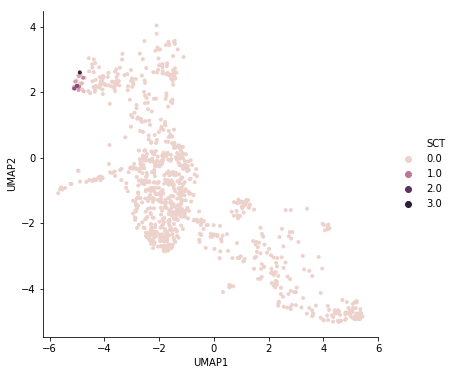

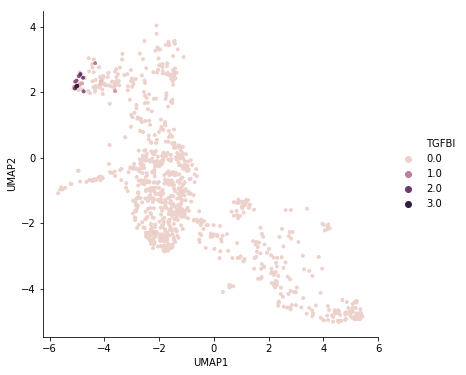

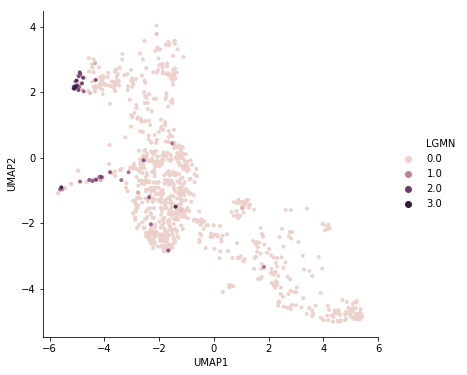

In [49]:
plot_genes(["SCT", "TGFBI", "LGMN"])  # Mono/Dendro

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


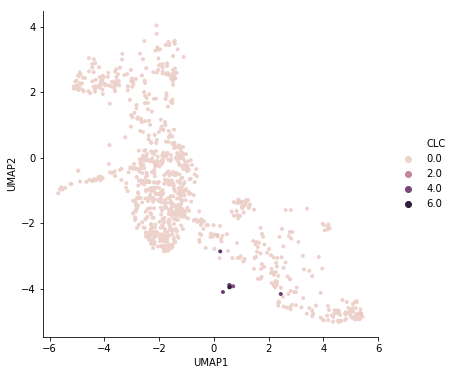

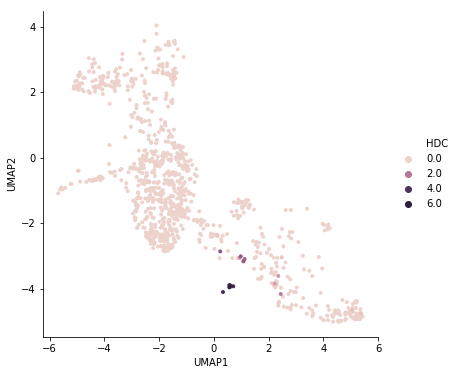

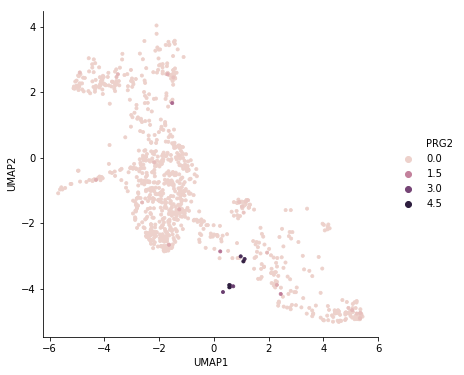

In [50]:
plot_genes(["CLC", "HDC", "PRG2"])  # Eosino/Baso/Mast

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


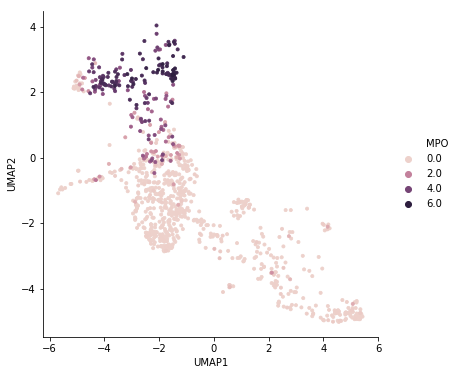

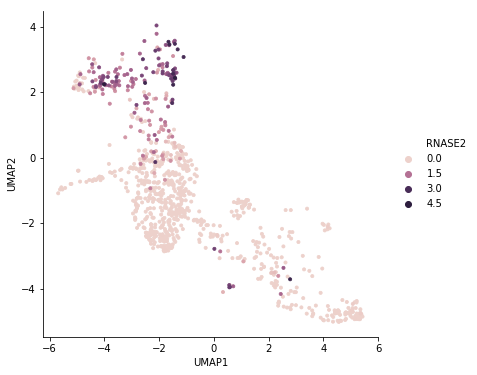

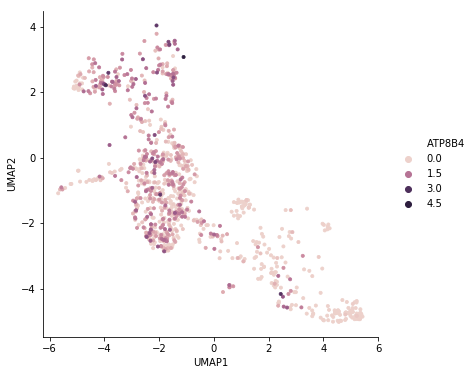

In [51]:
plot_genes(["MPO", "RNASE2", "ATP8B4"])  # Neutro (early)

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


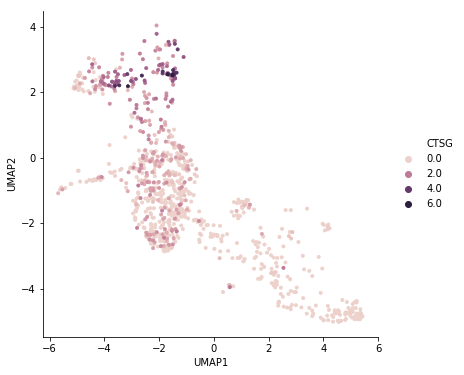

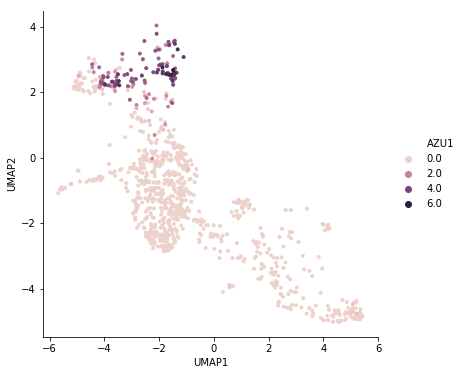

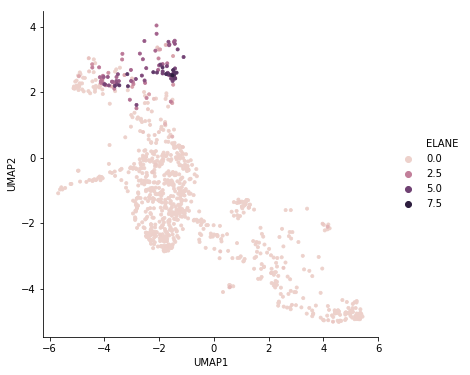

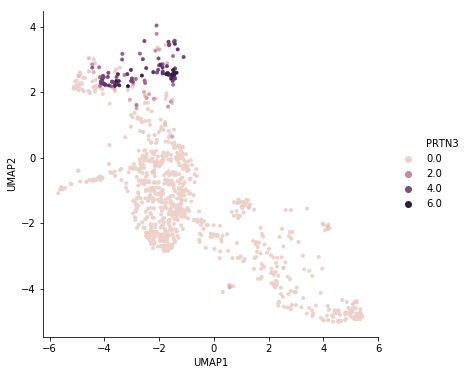

In [52]:
plot_genes(["CTSG", "AZU1", "ELANE", "PRTN3"])  # Neutro (inter)

[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...
[  Info   ] Using cached UMAP...


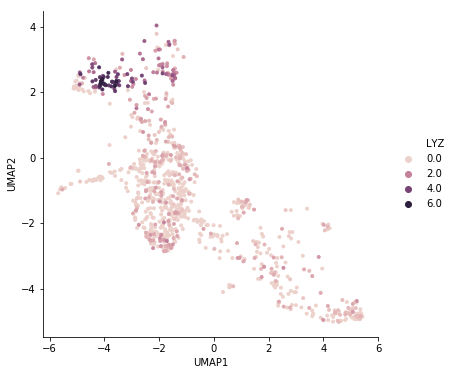

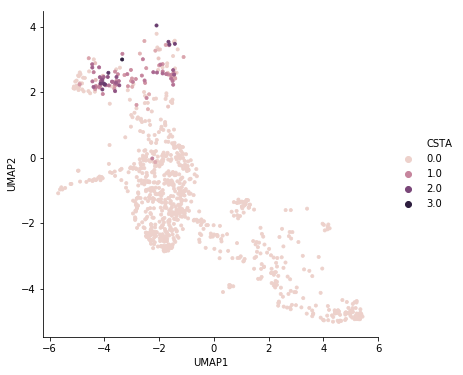

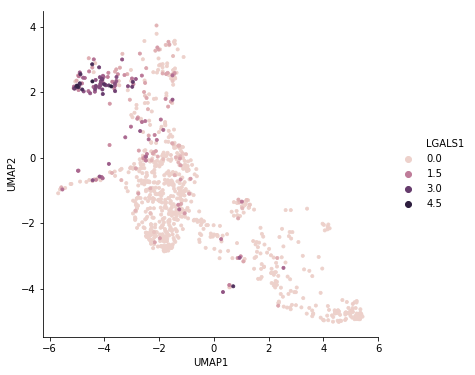

In [53]:
plot_genes(["LYZ", "CSTA", "LGALS1"])  # Neutro (late)

### scmap

In [54]:
velten2mouse.write_dataset("./velten2mouse.h5")

In [55]:
p = subprocess.Popen([
    "./run_scmap.R",
    "-r", "../../Datasets/data/Tusi/data.h5", "-n", "Tusi",
    "-q", "../../Notebooks/Case/HSC/velten2mouse.h5",
    "-o", "../../Notebooks/Case/HSC/cross_species_scmap.h5",
    "-g", "scmap_genes", "-s", "0", "--cluster-col", "organ"
], cwd="../../../Evaluation/scmap", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
(output, err) = p.communicate()
exit_code = p.wait()
print(output.decode())
print(err.decode())

Reading reference data...
Processing "../../Datasets/data/Tusi/data.h5"...
[1]  539 4763
Reading query data...
Performing scmap-cell...
[1] "Time: 2.492396 ms/cell"
Saving results...
Removing previous file...

Creating a generic function for ‘toJSON’ from package ‘jsonlite’ in package ‘googleVis’
Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.
Parameter k was not provided, will use k = sqrt(number_of_cells)
Done!



In [56]:
scmap_idx = cb.data.read_hybrid_path("./cross_species_scmap.h5//scmap_cell/nn/Tusi/cells").astype(int)
scmap_sim = cb.data.read_hybrid_path("./cross_species_scmap.h5//scmap_cell/nn/Tusi/similarities")

In [57]:
fate_pred_scmap = pd.DataFrame([
    tusi.obs.iloc[_idx[_sim >= 0.5] - 1, :].loc[:, fates].mean(axis=0)
    for _idx, _sim in zip(scmap_idx, scmap_sim)
])  # idx - 1 because R idx is 1 based

In [58]:
reject_mask = np.isnan(fate_pred_scmap.values).sum(axis=1) > 0
reject_mask.sum() / reject_mask.size

0.034782608695652174

In [59]:
for fate in fates:
    velten2mouse.obs[fate] = fate_pred_scmap[fate].values

In [60]:
tv_v = tv[tv.obs["dataset_name"] == "Velten_Smart-seq2", :]
tv_v.obs.loc[:, fates] = velten2mouse.obs.loc[:, fates]
colors = np.linspace(0, 1, 8)[:-1].reshape((-1, 1))
hue = np.matmul(tv_v.obs.loc[:, fates].values, colors)
hsl2hex = lambda x: '#%02x%02x%02x' % tuple(int(i * 255) for i in colorsys.hls_to_rgb(x, 0.6, 0.8))
tv_v.obs["color"] = np.vectorize(hsl2hex)(hue.ravel())

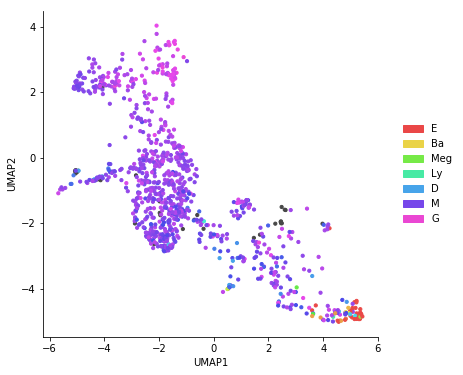

In [61]:
fig = plot_fate(tv_v, s=10, sort=True)
fig.savefig("velten_pred_scmap.pdf", bbox_inches="tight")